<a href="https://colab.research.google.com/github/roliveira15/Data_Science_Sales_Forecast/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1) Carregando as bibliotecas

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2) Importando o dataFrame

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot


In [321]:
! pip install pmdarima


from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 3) Importando Dataframe

In [322]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
#dateparse = lambda dates: pd.datetime.strptime(dates,'%d-%m-%Y') , parse_dates=['data'], index_col = 'data', date_parser=dateparse
df = pd.read_csv('https://raw.githubusercontent.com/roliveira15/Data_Science_Sales_Forecast/main/base.csv', sep = ';')
df.dtypes

tipo_frete                      object
peso                            object
valor_total_pedido              object
data                            object
abreviatura_uf                  object
regiao                          object
grupo_gerencial_produto         object
conta_numero_pedido_vendedor     int64
dtype: object

### 4) Converter o peso e o valor em float

Por padrão todas as variáveis do tipo string são armazenadas como object por esse motivo toda vez que tentamos modifcar de object para str, quando geramos o dtypes, as variáveis permanecem object. https://statisticsglobe.com/convert-object-data-type-string-pandas-dataframe-column-python





In [323]:

df['peso'] = df['peso'].str.replace(',','.').astype(float)
df['valor_total_pedido'] = df['valor_total_pedido'].str.replace(',','.').astype(float)

df['data'] = pd.to_datetime((df['data']))

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
dtype: object

###5) Criar uma coluna de Ano e mês

In [324]:
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
ano                                      int64
mes                                      int64
dtype: object

### 6) Criando estrutura para gerar gráfico de estruturas por ano, mes em função de peso e valor_total_pedido 

In [325]:
groupStructures = df.groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum()

groupStructures = groupStructures.round({'valor_total_pedido': 0,'peso': 0}).groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum().reset_index()
groupStructures.loc[(groupStructures['valor_total_pedido'] > 0) & (groupStructures['data'] >= '2020-09-01')]


,grupo_gerencial_produto,ano,mes,data,tipo_frete,regiao,abreviatura_uf,peso,valor_total_pedido,conta_numero_pedido_vendedor
3,AUTOMACAO,2020,9,2020-09-10,CIF,Sudeste,ES,1343.0,79000.0,1
5,AUTOMACAO,2020,11,2020-11-08,CIF,Sudeste,ES,811.0,56550.0,1
6,AUTOMACAO,2021,1,2021-01-04,CIF,Sudeste,ES,3830.0,333060.0,1
7,AUTOMACAO,2021,1,2021-01-05,CIF,Nordeste,RN,8845.0,610800.0,1
8,AUTOMACAO,2021,3,2021-03-08,CIF,Sudeste,SP,2542.0,2052312.0,1
...,...,...,...,...,...,...,...,...,...,...
4558,UNIVERSAL,2023,5,2023-05-15,FOB,Sudeste,ES,6628.0,10605.0,1
4559,UNIVERSAL,2023,6,2023-06-02,FOB,Sudeste,ES,8721.0,13954.0,1
4560,UNIVERSAL,2023,6,2023-06-04,FOB,Sudeste,ES,4955.0,7928.0,1
4561,UNIVERSAL,2023,7,2023-07-03,FOB,Sudeste,ES,8695.0,13912.0,1


6.1) Declara as variáveis principais do produto, data e região

In [420]:
PPint = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'DRIVE IN') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2024-01-01') & (groupStructures['regiao'] == 'Norte')]
PP = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'DRIVE IN') & (groupStructures['data'] >= '2022-01-01') & (groupStructures['data'] < '2023-01-01') & (groupStructures['regiao'] == 'Norte')]
PPanterior = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'DRIVE IN') & (groupStructures['data'] >= '2021-01-01') & (groupStructures['data'] < '2022-01-01') & (groupStructures['regiao'] == 'Norte')]
PPanteriorA = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'DRIVE IN') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2021-01-01') & (groupStructures['regiao'] == 'Norte')]

6.2) Criando gráfico por estrutura


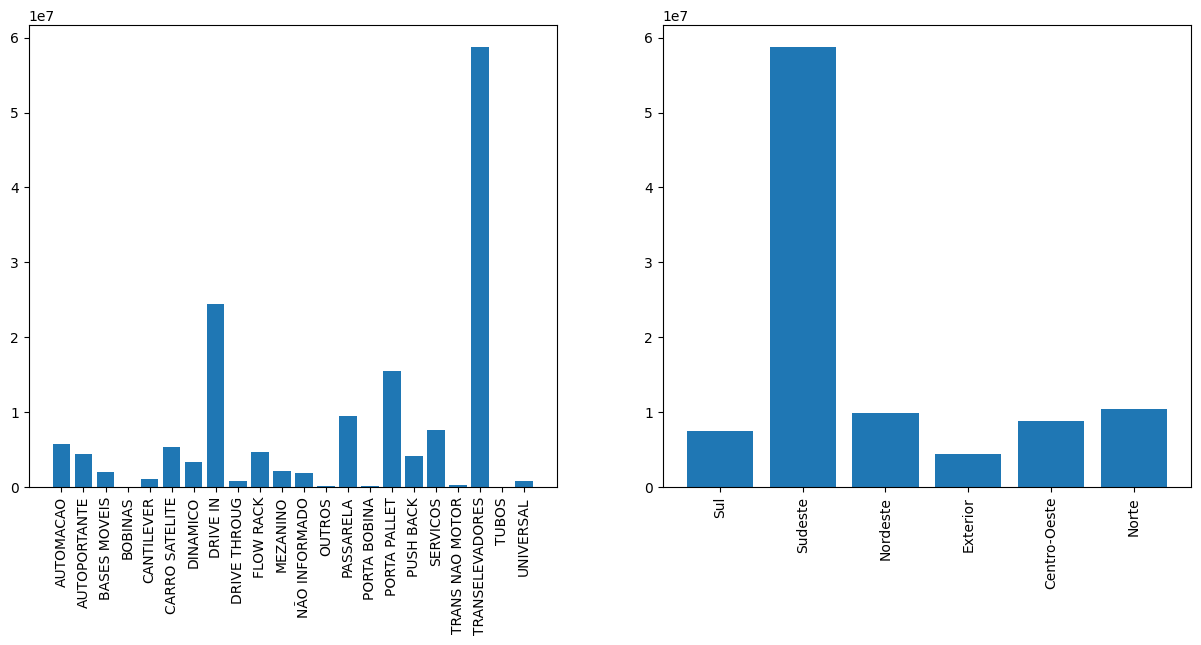

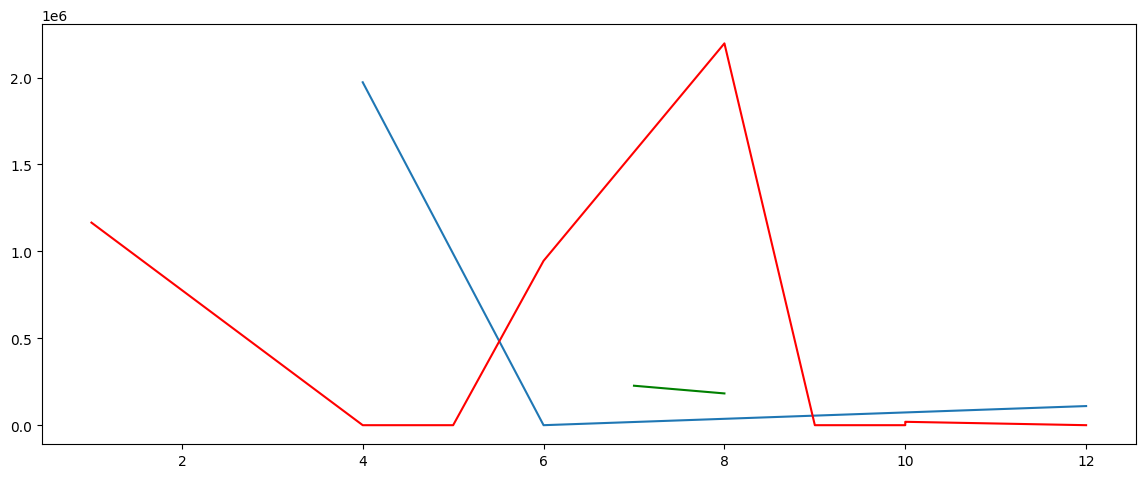

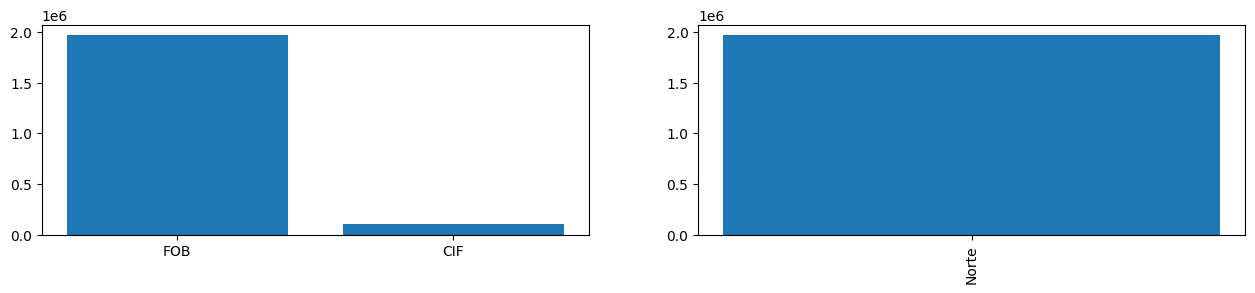

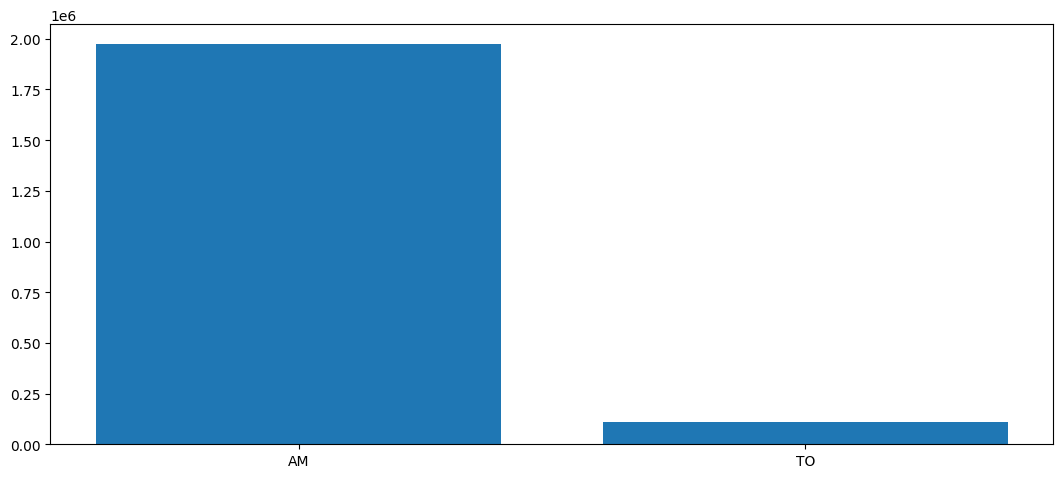

In [421]:

'''
                                  PORTA PALETE
'''
#Gráfico de barras de 
plt.figure(figsize = ((15, 6)))
plt.subplot(1, 2, 1)
plt.bar(groupStructures['grupo_gerencial_produto'], groupStructures['valor_total_pedido'])
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.bar(groupStructures['regiao'], groupStructures['valor_total_pedido'])
plt.xticks(rotation=90)

plt.figure(figsize = ((48, 12)))
#Anual
plt.subplot(2, 3, 3)
plt.plot(PP['mes'],PP['valor_total_pedido'])
plt.plot(PPanterior['mes'],PPanterior['valor_total_pedido'],color='red')
plt.plot(PPanteriorA['mes'],PPanteriorA['valor_total_pedido'],color='green')
plt.show()

plt.figure(figsize = ((24, 6)))
#Tipo de frete
plt.subplot(2, 3, 1)
plt.bar(PP['tipo_frete'], PP['valor_total_pedido'])
#Região
plt.subplot(2, 3, 2)
plt.bar(PP['regiao'], PP['valor_total_pedido'])
plt.xticks(rotation=90)
#Estado
plt.figure(figsize = ((44, 12)))
plt.subplot(2, 3, 4)
plt.bar(PP['abreviatura_uf'],PP['valor_total_pedido'])
plt.show()




Realizar a plotagem de todos os grupos para entender o comportadomento dos gráficos

In [487]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


modelo_preditivo = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'DRIVE IN') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2023-05-01') & (groupStructures['regiao'] == 'Sudeste') ]

modelo_preditivo['data_agrupada'] =  modelo_preditivo['ano'].map(str)+ '-' + modelo_preditivo['mes'].map(str) + '-01'

modelo_preditivo['data_agrupada'] = pd.to_datetime((modelo_preditivo['data_agrupada']))


modelo_preditivo = modelo_preditivo.drop(columns=['data','peso','conta_numero_pedido_vendedor','mes','ano']).round({'valor_total_pedido': 0}).groupby(['data_agrupada']).sum()

modelo_preditivo.index.names = ['data_agrupada']

#modelo_preditivo['valor_total_pedido_TESTE'] = modelo_preditivo['valor_total_pedido'].rolling(window = 5).mean()

modelo_preditivo['valor_total_pedido'] = modelo_preditivo['valor_total_pedido'].ewm(span=1).mean()
#modelo_preditivo.dropna(subset=['valor_total_pedido'],inplace=True)
display(modelo_preditivo)


<ipython-input-487-6d48ee29f00d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelo_preditivo['data_agrupada'] =  modelo_preditivo['ano'].map(str)+ '-' + modelo_preditivo['mes'].map(str) + '-01'
<ipython-input-487-6d48ee29f00d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelo_preditivo['data_agrupada'] = pd.to_datetime((modelo_preditivo['data_agrupada']))
<ipython-input-487-6d48ee29f00d>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future vers

,valor_total_pedido
data_agrupada,
2020-01-01,559875.0
2020-02-01,77649.0
2020-03-01,498760.0
2020-04-01,4354790.0
2020-05-01,127387.0
2020-06-01,140406.0
2020-07-01,4698850.0
2020-08-01,2397327.0
2020-09-01,9236026.0


,valor_total_pedido
count,3.800000e+01
mean,2.284268e+06
std,5.541763e+06
min,8.250000e+02
25%,1.302180e+05
50%,4.652690e+05
75%,1.842078e+06
max,3.257818e+07


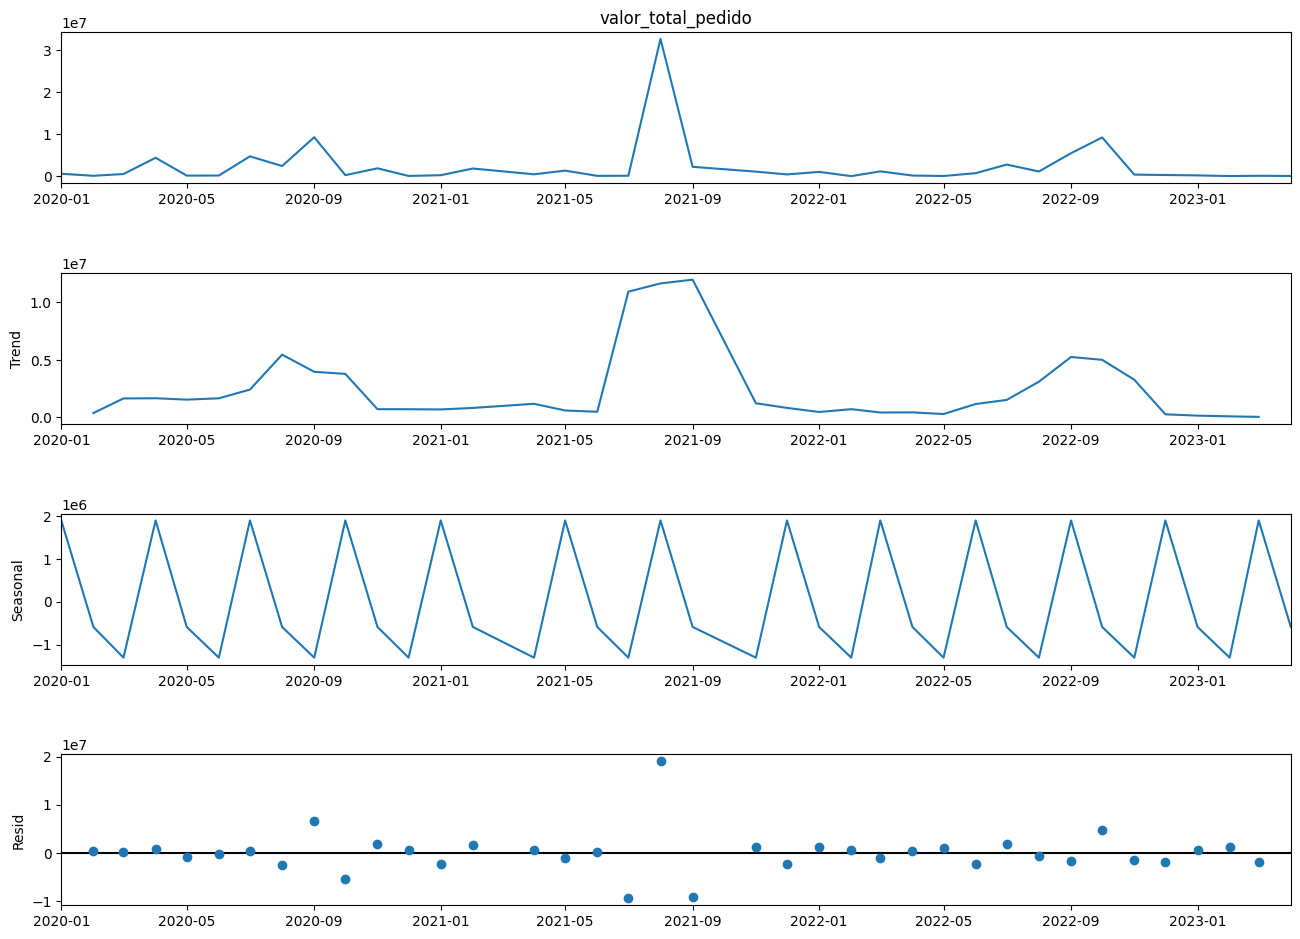

In [488]:

from statsmodels.tsa.seasonal import seasonal_decompose

#array = np.array(modelo_preditivo['valor_total_pedido'])

results = seasonal_decompose(x=modelo_preditivo['valor_total_pedido'],model='additive',period=3)

fig = results.plot()
fig.set_size_inches(13, 10)


modelo_preditivo.describe()


/usr/local/lib/python3.10/dist-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


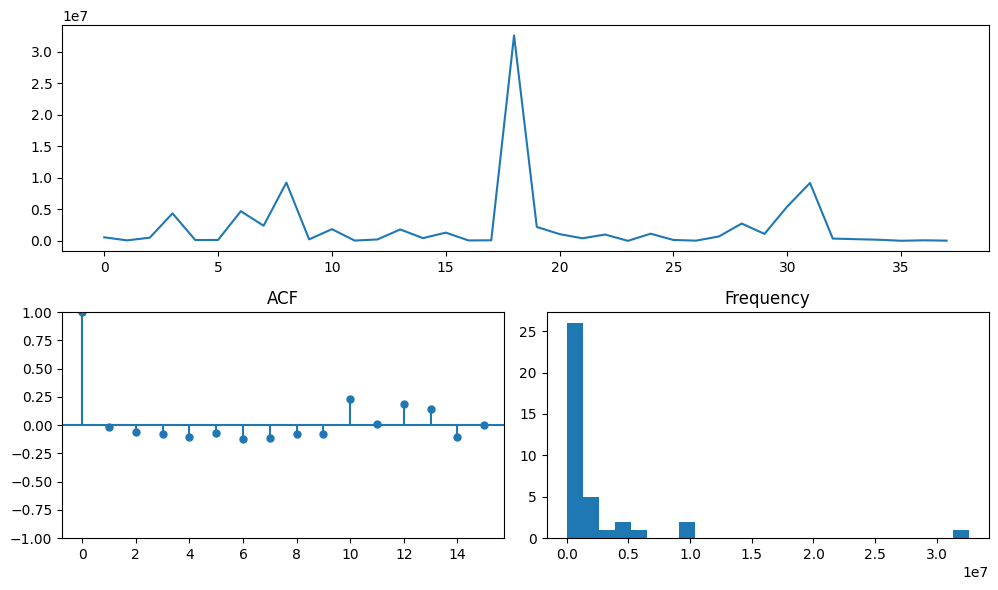

In [489]:
tsdisplay(modelo_preditivo,lag_max=15,figsize=(10,6))

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


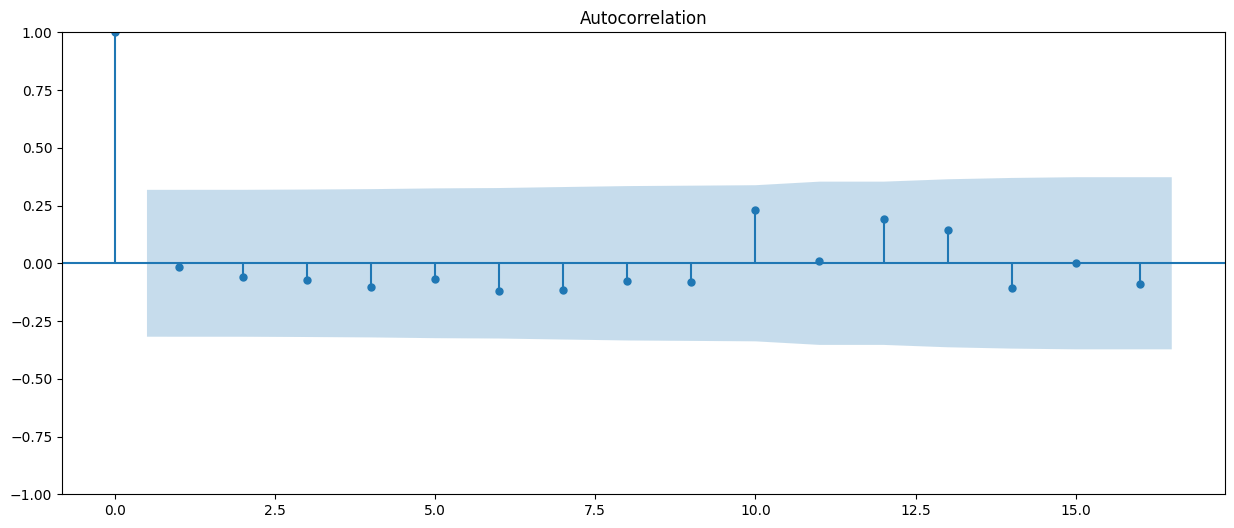

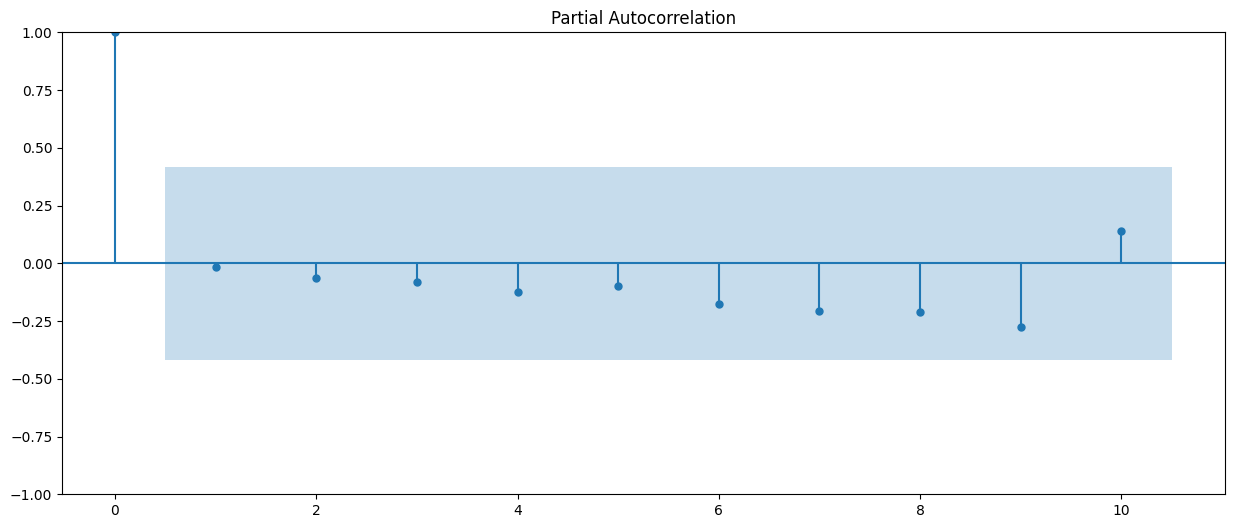

In [490]:
plot_acf(modelo_preditivo, alpha=0.05);
plot_pacf(modelo_preditivo,lags=10, alpha=0.01);

In [491]:
stepwise=auto_arima(modelo_preditivo,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=899.115, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=904.198, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=900.457, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=901.371, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=904.341, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=897.827, Time=0.06 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=898.930, Time=0.16 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=898.323, Time=0.08 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=900.925, Time=0.33 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=899.971, Time=0.08 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=903.029, Time=0.33 sec
 ARIMA(0,0,0)(0,1,1)[12]             : AIC=895.263, Time=0.05 sec
 ARIMA(0,0,0)(1,1,1)[12]             : AIC=896.538, Time=0.09 sec
 ARIMA(0,0,0)(0,1,2)[12]             : AIC=895.867, Time=0.14 sec
 ARIMA(0,0,0)(1,1,0)[12]         

In [492]:
stepwise

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [493]:
print(stepwise.aic())
print(stepwise.bic())

895.2626928255879
897.7788859016309


In [494]:
PPtreino = modelo_preditivo.loc['2020-01-01':'2023-01-01']

PPtest = modelo_preditivo.loc['2023-01-01':]

PPtest

,valor_total_pedido
data_agrupada,
2023-01-01,175525.0
2023-02-01,13520.0
2023-03-01,84625.0
2023-04-01,31284.0


In [495]:
stepwise.fit(PPtreino)

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [496]:
previsao = stepwise.predict(n_periods=len(PPtest))

previsao.index = PPtest.index
display(previsao)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


data_agrupada
2023-01-01     14263.192849
2023-02-01    585981.003004
2023-03-01    539216.871591
2023-04-01    224313.631587
dtype: float64

<Figure size 2000x500 with 0 Axes>

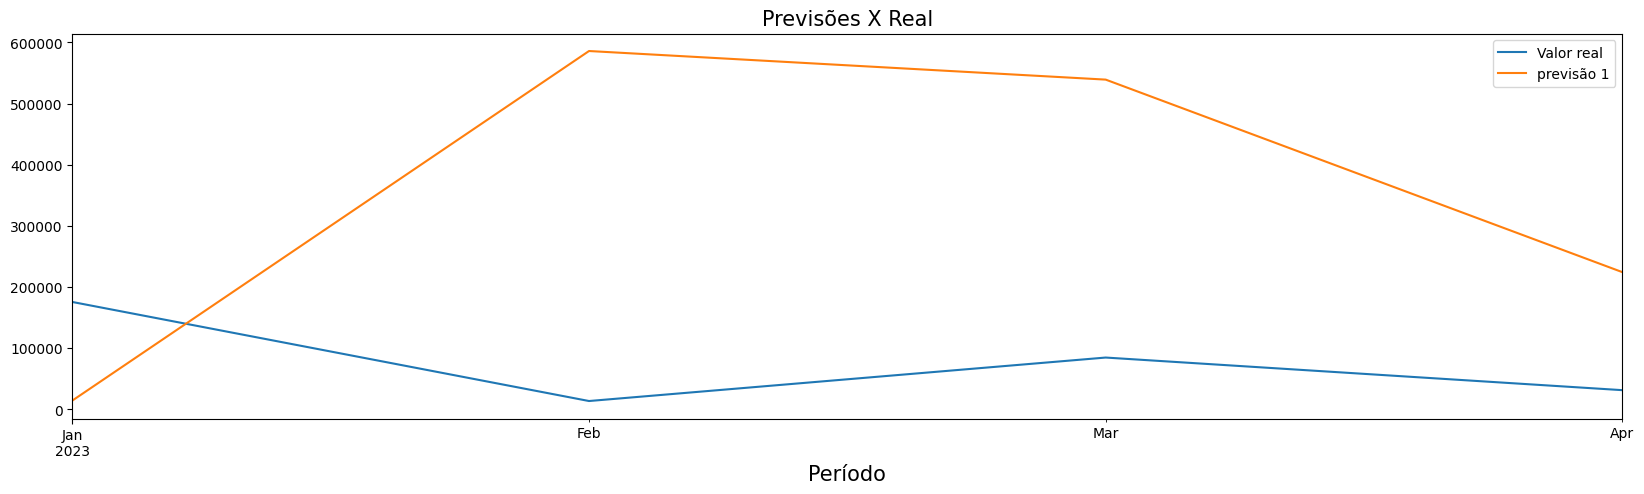

In [497]:
plt.figure(figsize=(20,5))
pd.concat([PPtest,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1','previsão 2']);



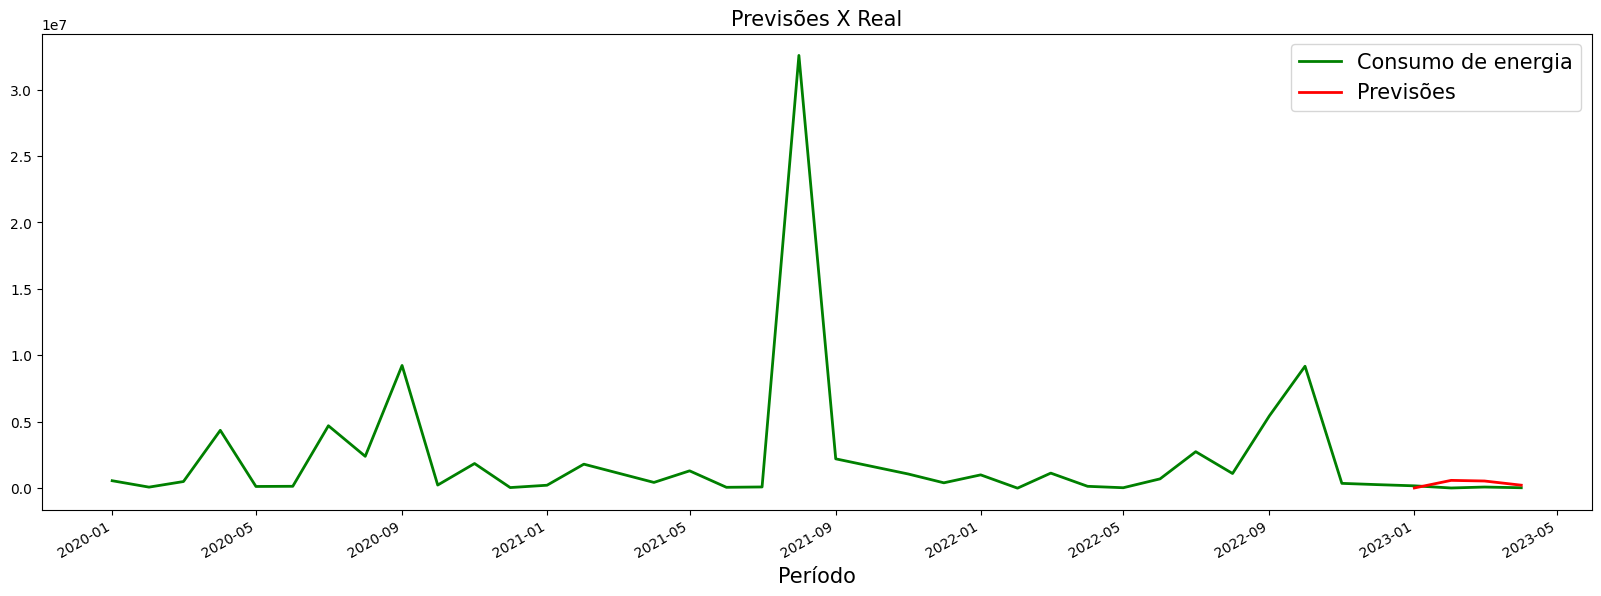

In [498]:
pd.concat([modelo_preditivo,previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Consumo de energia','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();
